In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [92]:
#Parameters to set
mu_0, sigma_0 = [-2., -2.], [[1., 0], [0, 1.]]
mu_1, sigma_1 = [3., 3.], [[2., 0], [0, 2.]]

In [93]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [94]:
d0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(mu_0), torch.tensor(sigma_0))
d1 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(mu_1), torch.tensor(sigma_1))

In [96]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.0145, -0.3480]), tensor(0.2254)]


In [97]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = F.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Ошибка после 0 итераций: 1.264938
Ошибка после 1 итераций: 0.260847
Ошибка после 2 итераций: 0.148104
Ошибка после 3 итераций: 0.107901
Ошибка после 4 итераций: 0.086032
Ошибка после 5 итераций: 0.072542
Ошибка после 6 итераций: 0.063082
Ошибка после 7 итераций: 0.056178
Ошибка после 8 итераций: 0.051553
Ошибка после 9 итераций: 0.046873
Ошибка после 10 итераций: 0.043693
Ошибка после 11 итераций: 0.040970
Ошибка после 12 итераций: 0.038474
Ошибка после 13 итераций: 0.036133
Ошибка после 14 итераций: 0.034521
Ошибка после 15 итераций: 0.032977
Ошибка после 16 итераций: 0.031419
Ошибка после 17 итераций: 0.030380
Ошибка после 18 итераций: 0.029102
Ошибка после 19 итераций: 0.028254


In [226]:
x_scale = np.linspace(-10,10,100)
X, Y = np.meshgrid(x_scale, x_scale)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
d0_pdf = multivariate_normal(mu_0, sigma_0).pdf(pos) 
d1_pdf = multivariate_normal(mu_1, sigma_1).pdf(pos)

In [227]:
ratio = d1_pdf / (d1_pdf + d0_pdf)

In [228]:
a = np.meshgrid(x_scale, x_scale)
b = np.asarray(a)

x_tensor = torch.tensor(np.transpose(b), dtype=torch.float)

with torch.no_grad():
     dist = F.sigmoid(layer(x_tensor)).numpy()

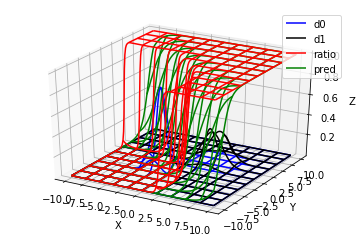

In [229]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_wireframe(X, Y, d0_pdf*5, rstride=10, cstride=10, color='blue', label='d0')
ax.plot_wireframe(X, Y, d1_pdf*5, rstride=10, cstride=10, color='black', label='d1')
ax.plot_wireframe(X, Y, ratio, rstride=10, cstride=10, color='red', label='ratio')
ax.plot_wireframe(X, Y, dist[:,:,-1], rstride=10, cstride=10, color='green', label='pred')
plt.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()